In [2]:
from natsort import natsorted
import argparse
import os
from collections import OrderedDict
import io
import contextlib
import itertools

import shutil
import pickle
import numpy as np
import mmcv
from mmdet.datasets.api_wrappers import COCO, COCOeval

from base_config import get_config
from test import map_test
from mmdet_tools import mmdet_test

In [3]:
experiment_names = ['baseline']
pretrain_percentages = range(10, 91, 10)
experiment_names += ['pretrain' + str(percent) for percent in pretrain_percentages]
experiment_names

['baseline',
 'pretrain10',
 'pretrain20',
 'pretrain30',
 'pretrain40',
 'pretrain50',
 'pretrain60',
 'pretrain70',
 'pretrain80',
 'pretrain90']

In [4]:
experiment_checkpoints = []

for experiment_name in experiment_names:
  checkpoints = os.listdir(os.path.join('../vinbig_output', experiment_name))
  checkpoints = natsorted(checkpoints)
  checkpoints = [p for p in checkpoints if 'epoch_' in p]
  checkpoint = os.path.join('../vinbig_output', experiment_name, checkpoints[-1])
  experiment_checkpoints.append(checkpoint)

experiment_checkpoints

['../vinbig_output/baseline/epoch_15.pth',
 '../vinbig_output/pretrain10/epoch_15.pth',
 '../vinbig_output/pretrain20/epoch_15.pth',
 '../vinbig_output/pretrain30/epoch_15.pth',
 '../vinbig_output/pretrain40/epoch_15.pth',
 '../vinbig_output/pretrain50/epoch_15.pth',
 '../vinbig_output/pretrain60/epoch_15.pth',
 '../vinbig_output/pretrain70/epoch_15.pth',
 '../vinbig_output/pretrain80/epoch_15.pth',
 '../vinbig_output/pretrain90/epoch_15.pth']

In [142]:
def print_log(msg, logger):
    pass
    #print(msg)

def evaluate(dataset,
                results,
                metric='bbox',
                logger=None,
                jsonfile_prefix=None,
                classwise=False,
                proposal_nums=(100, 300, 1000),
                iou_thrs=None,
                metric_items=None):
    """Evaluation in COCO protocol.
    Args:
        results (list[list | tuple]): Testing results of the dataset.
        metric (str | list[str]): Metrics to be evaluated. Options are
            'bbox', 'segm', 'proposal', 'proposal_fast'.
        logger (logging.Logger | str | None): Logger used for printing
            related information during evaluation. Default: None.
        jsonfile_prefix (str | None): The prefix of json files. It includes
            the file path and the prefix of filename, e.g., "a/b/prefix".
            If not specified, a temp file will be created. Default: None.
        classwise (bool): Whether to evaluating the AP for each class.
        proposal_nums (Sequence[int]): Proposal number used for evaluating
            recalls, such as recall@100, recall@1000.
            Default: (100, 300, 1000).
        iou_thrs (Sequence[float], optional): IoU threshold used for
            evaluating recalls/mAPs. If set to a list, the average of all
            IoUs will also be computed. If not specified, [0.50, 0.55,
            0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95] will be used.
            Default: None.
        metric_items (list[str] | str, optional): Metric items that will
            be returned. If not specified, ``['AR@100', 'AR@300',
            'AR@1000', 'AR_s@1000', 'AR_m@1000', 'AR_l@1000' ]`` will be
            used when ``metric=='proposal'``, ``['mAP', 'mAP_50', 'mAP_75',
            'mAP_s', 'mAP_m', 'mAP_l']`` will be used when
            ``metric=='bbox' or metric=='segm'``.
    Returns:
        dict[str, float]: COCO style evaluation metric.
    """
    
    metrics = metric if isinstance(metric, list) else [metric]
    allowed_metrics = ['bbox', 'segm', 'proposal', 'proposal_fast']
    for metric in metrics:
        if metric not in allowed_metrics:
            raise KeyError(f'metric {metric} is not supported')
    if iou_thrs is None:
        iou_thrs = np.linspace(
            .5, 0.95, int(np.round((0.95 - .5) / .05)) + 1, endpoint=True)
    if metric_items is not None:
        if not isinstance(metric_items, list):
            metric_items = [metric_items]

    result_files, tmp_dir = dataset.format_results(results, jsonfile_prefix)

    eval_results = OrderedDict()
    cocoGt = dataset.coco

    results_per_category = []

    for metric in metrics:
        msg = f'Evaluating {metric}...'
        if logger is None:
            msg = '\n' + msg
        print_log(msg, logger=logger)

        if metric == 'proposal_fast':
            ar = dataset.fast_eval_recall(
                results, proposal_nums, iou_thrs, logger='silent')
            log_msg = []
            for i, num in enumerate(proposal_nums):
                eval_results[f'AR@{num}'] = ar[i]
                log_msg.append(f'\nAR@{num}\t{ar[i]:.4f}')
            log_msg = ''.join(log_msg)
            print_log(log_msg, logger=logger)
            continue

        iou_type = 'bbox' if metric == 'proposal' else metric
        if metric not in result_files:
            raise KeyError(f'{metric} is not in results')
        try:
            predictions = mmcv.load(result_files[metric])
            if iou_type == 'segm':
                # Refer to https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/coco.py#L331  # noqa
                # When evaluating mask AP, if the results contain bbox,
                # cocoapi will use the box area instead of the mask area
                # for calculating the instance area. Though the overall AP
                # is not affected, this leads to different
                # small/medium/large mask AP results.
                for x in predictions:
                    x.pop('bbox')
                warnings.simplefilter('once')
                warnings.warn(
                    'The key "bbox" is deleted for more accurate mask AP '
                    'of small/medium/large instances since v2.12.0. This '
                    'does not change the overall mAP calculation.',
                    UserWarning)
            cocoDt = cocoGt.loadRes(predictions)
        except IndexError:
            print_log(
                'The testing results of the whole dataset is empty.',
                logger=logger,
                level=logging.ERROR)
            break

        cocoEval = COCOeval(cocoGt, cocoDt, iou_type)
        cocoEval.params.catIds = dataset.cat_ids
        cocoEval.params.imgIds = dataset.img_ids
        cocoEval.params.maxDets = list(proposal_nums)
        cocoEval.params.iouThrs = iou_thrs
        # mapping of cocoEval.stats
        coco_metric_names = {
            'mAP': 0,
            'mAP_50': 1,
            'mAP_75': 2,
            'mAP_s': 3,
            'mAP_m': 4,
            'mAP_l': 5,
            'AR@100': 6,
            'AR@300': 7,
            'AR@1000': 8,
            'AR_s@1000': 9,
            'AR_m@1000': 10,
            'AR_l@1000': 11
        }
        if metric_items is not None:
            for metric_item in metric_items:
                if metric_item not in coco_metric_names:
                    raise KeyError(
                        f'metric item {metric_item} is not supported')

        if metric == 'proposal':
            cocoEval.params.useCats = 0
            cocoEval.evaluate()
            cocoEval.accumulate()

            # Save coco summarize print information to logger
            redirect_string = io.StringIO()
            with contextlib.redirect_stdout(redirect_string):
                cocoEval.summarize()
            print_log('\n' + redirect_string.getvalue(), logger=logger)

            if metric_items is None:
                metric_items = [
                    'AR@100', 'AR@300', 'AR@1000', 'AR_s@1000',
                    'AR_m@1000', 'AR_l@1000'
                ]

            for item in metric_items:
                val = float(
                    f'{cocoEval.stats[coco_metric_names[item]]:.3f}')
                eval_results[item] = val
        else:
            cocoEval.evaluate()
            cocoEval.accumulate()

            # Save coco summarize print information to logger
            redirect_string = io.StringIO()
            with contextlib.redirect_stdout(redirect_string):
                cocoEval.summarize()
            print_log('\n' + redirect_string.getvalue(), logger=logger)
            
            if classwise:  # Compute per-category AP
                # Compute per-category AP
                # from https://github.com/facebookresearch/detectron2/
                precisions = cocoEval.eval['precision']
                # precision: (iou, recall, cls, area range, max dets)
                assert len(dataset.cat_ids) == precisions.shape[2]

                for idx, catId in enumerate(dataset.cat_ids):
                    # area range index 0: all area ranges
                    # max dets index -1: typically 100 per image
                    nm = dataset.coco.loadCats(catId)[0]
                    precision = precisions[:, :, idx, 0, -1]
                    precision = precision[precision > -1]
                    if precision.size:
                        ap = np.mean(precision)
                    else:
                        ap = float('nan')
                    results_per_category.append(
                        (f'{nm["name"]}', float(ap)))

                num_columns = min(6, len(results_per_category) * 2)
                results_flatten = list(
                    itertools.chain(*results_per_category))
                headers = ['category', 'AP'] * (num_columns // 2)
                results_2d = itertools.zip_longest(*[
                    results_flatten[i::num_columns]
                    for i in range(num_columns)
                ])

            if metric_items is None:
                metric_items = [
                    'mAP', 'mAP_50', 'mAP_75', 'mAP_s', 'mAP_m', 'mAP_l'
                ]

            for metric_item in metric_items:
                key = f'{metric}_{metric_item}'
                val = float(
                    f'{cocoEval.stats[coco_metric_names[metric_item]]:.3f}'
                )
                eval_results[key] = val
            ap = cocoEval.stats[:6]
            eval_results[f'{metric}_mAP_copypaste'] = (
                f'{ap[0]:.3f} {ap[1]:.3f} {ap[2]:.3f} {ap[3]:.3f} '
                f'{ap[4]:.3f} {ap[5]:.3f}')
    if tmp_dir is not None:
        tmp_dir.cleanup()
    return eval_results, results_per_category

In [145]:
results = {}

results_dir = 'results'
if os.path.exists(results_dir):
  shutil.rmtree(results_dir)

os.makedirs(results_dir)

results_avg = []
results_avg_ar = []
results_classwise = []

for experiment_name, checkpoint in zip(experiment_names, experiment_checkpoints):
  cfg = get_config()
  args = argparse.Namespace(eval='bbox', out='results/' + experiment_name + '.pkl', checkpoint=None, work_dir=results_dir, fuse_conv_bn=None, 
    gpu_ids=None, format_only=None, show=None, show_dir=None, show_score_thr=0.3, gpu_collect=None,
    tmpdir=None, cfg_options=None, options=None, launcher='none', eval_options=None, local_rank=0)
  dataset, outputs = mmdet_test.get_outputs(cfg, checkpoint, args)
  metrics, results_per_category = evaluate(dataset, outputs, metric='bbox', classwise=True)
  metrics_ar, _ = evaluate(dataset, outputs, metric='proposal')
  results_avg.append(metrics)
  results_avg_ar.append(metrics_ar)
  results_classwise.append(results_per_category)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
load checkpoint from local path: ../vinbig_output/baseline/epoch_15.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 879/879, 52.6 task/s, elapsed: 17s, ETA:     0sLoading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.44s).
Accumulating evaluation results...
DONE (t=0.42s).
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.54s).
Accumulating evaluation results...
DONE (t=0.27s).
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
load checkpoint from local path: ../vinbig_output/pretrain10/epoch_15.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 879/879, 53.1 task/s, elapsed: 17s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluat

([<matplotlib.axis.XTick at 0x7f2dccca62e0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

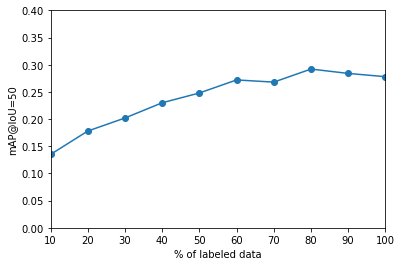

In [7]:
import matplotlib.pyplot as plt
percentages = [100] + [100 - p for p in pretrain_percentages]
map_50s = [r['bbox_mAP_50'] for r in results_avg]

plt.plot(percentages, map_50s, '-o')
plt.ylim(0, 0.4)
plt.xlim(10, 100)
plt.ylabel('mAP@IoU=50')
plt.xlabel('% of labeled data')
plt.xticks(np.arange(10, 101, 10))

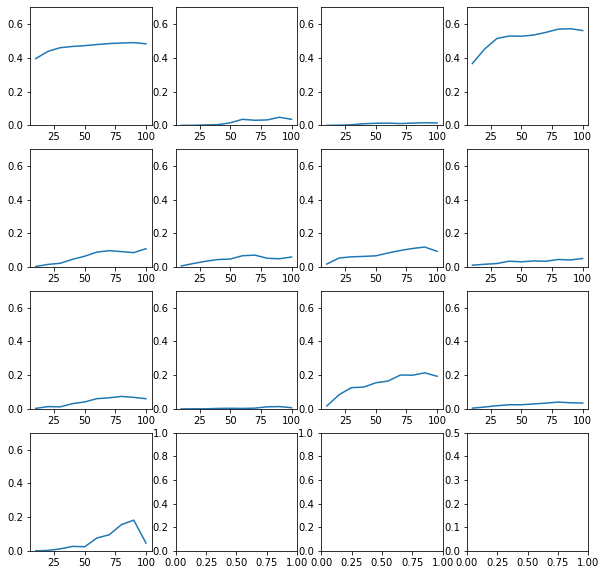

In [8]:
classes = [key for key, _ in results_classwise[0]]
results_classwise_dict = [dict(r) for r in results_classwise]
class_to_results = {}
for class_name in classes:
    class_to_results[class_name] = [r[class_name] for r in results_classwise_dict]

fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(10, 10))
class_names = list(class_to_results.keys())
axs = axs.flatten()
plt.ylim(0, 0.5)
for i in range(len(axs)):
    if i >= 13:
        break
    
    ax = axs[i]
    class_name = class_names[i]
    aps = class_to_results[class_name]
    aps = list(map(float, aps))
    ax.plot(percentages, aps)
    ax.set_ylim(0, 0.7)

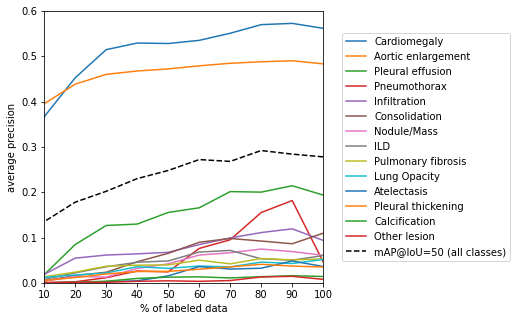

In [115]:
import seaborn as sns
from matplotlib.colors import ListedColormap

items = list(class_to_results.items())
items = [(k, list(map(float, aps))) for (k, aps) in items]
items.sort(key=lambda i: max(i[1]), reverse=True)

fig, ax = plt.subplots(figsize=(5, 5))

evenly_spaced_interval = np.linspace(0, 1, len(items))
cmap = ListedColormap(sns.color_palette(n_colors=14))
colors = [cmap(x) for x in evenly_spaced_interval]

for (i, (class_name, aps)) in enumerate(items):
  label = class_name.replace('_', ' ')
  plt.plot(percentages, aps, label=label, color=colors[i])

plt.plot(percentages, map_50s, '--', color='black', label='mAP@IoU=50 (all classes)')

plt.ylim(0, 0.6)

plt.ylabel('average precision')
plt.xlabel('% of labeled data')
plt.xticks(np.arange(10, 101, 10))
plt.xlim(10, 100)
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))

plt.tight_layout()

plt.savefig('figures/map_graph.png')

In [85]:
from test import get_training_datasets, _classes
from mmdet.datasets import build_dataset
from train import get_config

img_norm_cfg = dict(
  mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)

pipeline = [
  dict(type='LoadImageFromFile'),
  dict(type='LoadAnnotations', with_bbox=True),
  dict(type='RandomFlip', flip_ratio=0.),
  dict(type='Resize', img_scale=(512, 512), keep_ratio=True),
  dict(type='Normalize', **img_norm_cfg),
  dict(type='Pad', size_divisor=32),
  dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels']),
]

cfg.data.train['dataset'].pipeline = pipeline
cfg.data.train['dataset'].take_first_percent = 1
cfg.data.train['take_first_percent'] = 1
cfg.data.val.pipeline = pipeline

train = build_dataset(cfg.data.train['dataset'])
rebalanced = build_dataset(cfg.data.train)
datasets = [train, rebalanced]
titles = ['Original dataset', 'Rebalanced dataset']

hists = []

for i in range(len(datasets)):
  labels = []
  dataset = datasets[i]
  for data in dataset:
    #labels += np.unique(data['gt_labels'].data).tolist()
    labels += np.unique(data['gt_labels'].data).tolist()

  rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
  hist, edges = np.histogram(labels, bins=len(_classes))
  hists.append(hist)

sort_idxs = np.argsort(hist)[::-1]
for i in range(len(hists)):
  hists[i] = hists[i][sort_idxs]
_classes = np.array(_classes)[sort_idxs].tolist()

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Taking first 3075 of original dataset (3075), (100.0)%
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Taking first 3075 of original dataset (3075), (100.0)%


[array([2178, 1560, 1276, 1616, 1057,  843,  885,  640,  491,  301,  355,
        314,  161,   81]), array([3782, 3183, 2671, 2640, 2490, 1997, 1977, 1423, 1150,  926,  763,
        679,  498,  324])]


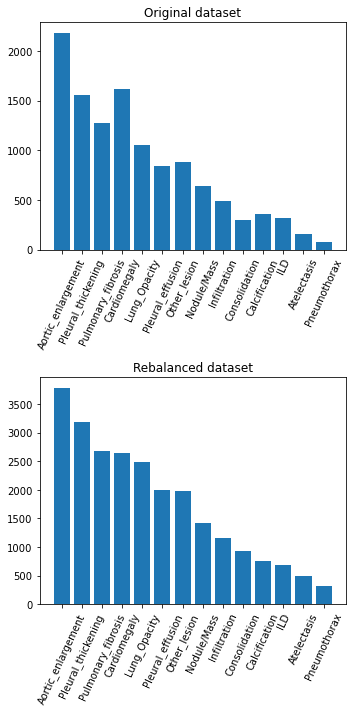

In [86]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(5, 10))
axs = axs.flatten()

print(hists)

for i in range(len(hists)):
  hist = hists[i]
  ax = axs[i]
  ax.bar(np.arange(len(_classes)), hist)
  ax.set_xticks(np.arange(len(_classes)), _classes, rotation=65)
  ax.set_title(titles[i])
plt.tight_layout()

In [100]:
hists = hists[::-1]

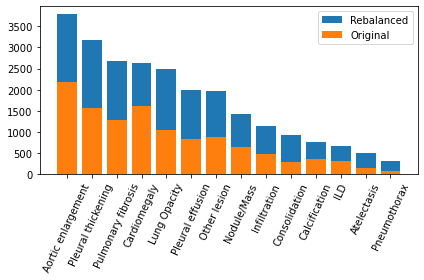

In [114]:
labels = ['Rebalanced', 'Original']
for i in range(len(hists)):
  hist = hists[i]
  plt.bar(np.arange(len(_classes)), hist, label=labels[i])

classes_pretty = [c.replace('_', ' ') for c in _classes]
plt.xticks(np.arange(len(_classes)), classes_pretty, rotation=65)
plt.legend()
plt.tight_layout()
plt.savefig('figures/rebalace.png')

In [161]:
table_pairs = list(zip(percentages, results_avg, results_avg_ar))
for (percentage, metric, metric_ar) in table_pairs:
  if percentage == 100:
    name = 'Baseline'
  else:
    name = f'Pretrained {100 - int(percentage)}\%'
  number_of_examples = int(3075 * (int(percentage) / 100.))
  print(f'{name} & {metric["bbox_mAP"]:.3f} & {metric["bbox_mAP_50"]:.3f} & {metric["bbox_mAP_s"]:.3f} & {metric_ar["AR@100"]:.3f} & {metric_ar["AR_s@1000"]:.3f} & {number_of_examples} \\\\ \\hline')

Baseline & 0.129 & 0.278 & 0.021 & 0.412 & 0.154 & 3075 \\ \hline
Pretrained 10\% & 0.142 & 0.284 & 0.026 & 0.413 & 0.156 & 2767 \\ \hline
Pretrained 20\% & 0.139 & 0.292 & 0.020 & 0.412 & 0.158 & 2460 \\ \hline
Pretrained 30\% & 0.130 & 0.268 & 0.014 & 0.402 & 0.146 & 2152 \\ \hline
Pretrained 40\% & 0.123 & 0.272 & 0.014 & 0.394 & 0.131 & 1845 \\ \hline
Pretrained 50\% & 0.109 & 0.248 & 0.011 & 0.387 & 0.131 & 1537 \\ \hline
Pretrained 60\% & 0.104 & 0.230 & 0.011 & 0.378 & 0.120 & 1230 \\ \hline
Pretrained 70\% & 0.095 & 0.202 & 0.007 & 0.363 & 0.108 & 922 \\ \hline
Pretrained 80\% & 0.081 & 0.178 & 0.006 & 0.338 & 0.089 & 615 \\ \hline
Pretrained 90\% & 0.060 & 0.135 & 0.003 & 0.303 & 0.064 & 307 \\ \hline


In [162]:
print(results_avg_ar[0])

OrderedDict([('AR@100', 0.412), ('AR@300', 0.412), ('AR@1000', 0.412), ('AR_s@1000', 0.154), ('AR_m@1000', 0.431), ('AR_l@1000', 0.562)])
